In [1]:
import cv2 as cv
import numpy as np

In [2]:
base_path = f"D:/Guy_Gilad/Exp2_GuyGilad/logs_yolo"
input_bboxes_path = f"{base_path}/bboxes.csv"

exp_config_path = f"{base_path}/experiment_config.json"
yolo_config_path = f"{base_path}/yolo_config.json"


In [3]:
from evaluation.simulator import *
from evaluation.sim_controllers import *
from utils.path_utils import Files
from evaluation.config import *

experiment_config = ExperimentConfig.load_json(exp_config_path)
yolo_config = YoloConfig.load_json(yolo_config_path)

time_config = TimingConfig(
    frames_per_sec=60,
    imaging_time_ms=100,
    pred_time_ms=40,
    moving_time_ms=50,
    px_per_mm=92,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.22, 0.21),
)

log_config = LogConfig(
    root_folder="logs",
    save_mic_view=False,
    save_cam_view=False,
    save_err_view=False,
)

c:\Users\slevylab\AppData\Local\miniforge3\envs\bio_proj\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [4]:
weights = np.asanyarray([   0.043858 , 7.4848e-06 , 2.4353e-07 , 0.00026733 , 2.7041e-05 ,   0.085828 ,   0.097627  ,   0.70979  ,   0.69093]
)
sample_times = np.asanyarray(
    [
        0,
        5,
        9,
        -time_config.cycle_length + 0,
        -time_config.cycle_length + 5,
        -time_config.cycle_length + 9,
        -2 * time_config.cycle_length + 0,
        -2 * time_config.cycle_length + 5,
        -2 * time_config.cycle_length + 9,
    ]
)

In [5]:
from evaluation.sim_controllers.test_controller1 import TestController1
from evaluation.sim_controllers.polyfit_controller import PolyfitController

#sim_controller = YoloController(time_config, yolo_config)
sim_controller = TestController1(time_config, input_bboxes_path)
#sim_controller = PolyfitController(time_config, input_bboxes_path, degree=1, weights=weights, sample_times=sample_times)
#sim_controller = OptimalController(time_config, input_bboxes_path)
#sim_controller = CsvController(time_config, input_bboxes_path)
log_controller = LoggingController(sim_controller, log_config)
sim = Simulator(time_config, experiment_config, log_controller, reader=None)

In [6]:
sim.run(visualize=False, wait_key=False)

Simulation Progress:   0%|          | 0/6800 [00:00<?, ?cycle/s]

Correlation Coefficient: nan
Correlation Slope: 0.00


,wrm_speed,bbox_area_diff
count,6792.000000,6791.000000
mean,0.474760,0.071587
std,0.301119,0.099093
min,0.046290,0.000000
10%,0.256564,0.000000
20%,0.304002,0.000000
30%,0.350246,0.000000
40%,0.398298,0.016200
50%,0.441785,0.039770
60%,0.490326,0.064970


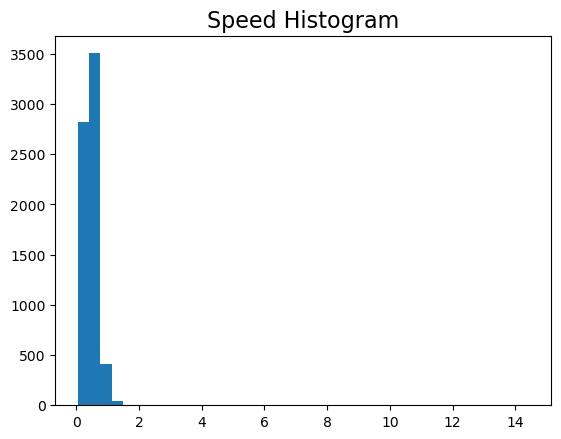

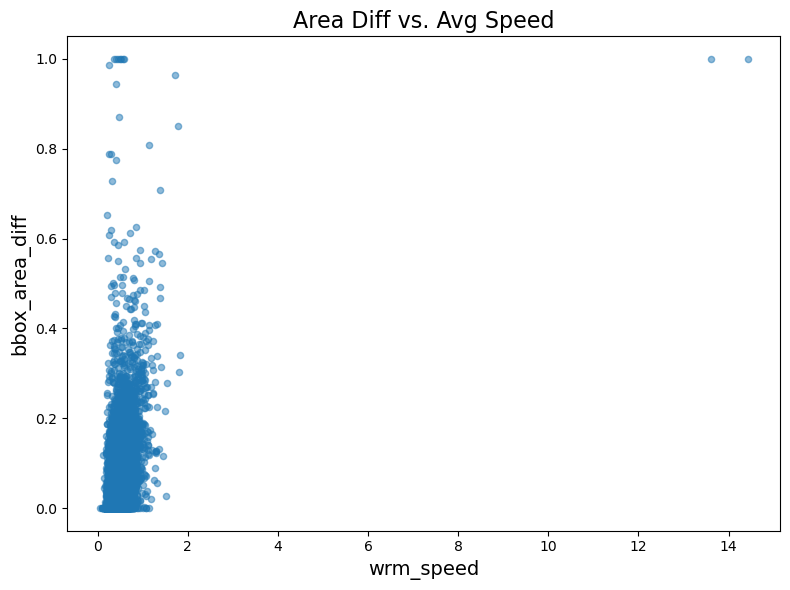

In [7]:
from evaluation.analysis import Plotter
from evaluation.config import *

plt = Plotter(f"logs/bboxes.csv", time_config)
plt.plot_speed_hist()
plt.plot_area_vs_speed(min_speed=0.)

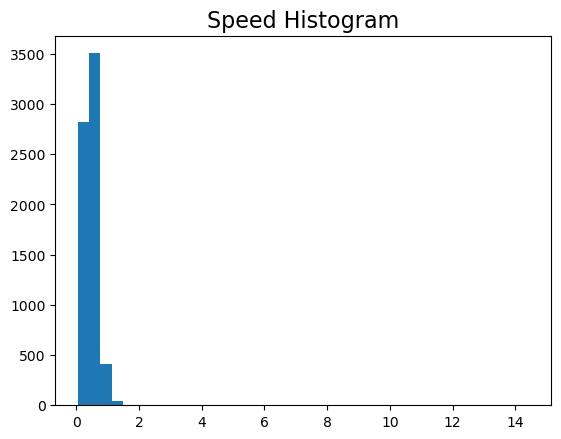

In [8]:
plt.plot_speed_hist()

In [9]:
cv.destroyAllWindows()
raise Exception("Finished")

Exception: Finished

In [ ]:
from evaluation.sim_controllers.polyfit_controller import WeightEvaluator

# input_offsets = np.asanyarray([0, 3, 6, 9])

input_offsets = np.asanyarray(
    [
        0,
        5,
        9,
        -time_config.cycle_length + 0,
        -time_config.cycle_length + 5,
        -time_config.cycle_length + 9,
        -2 * time_config.cycle_length + 0,
        -2 * time_config.cycle_length + 5,
        -2 * time_config.cycle_length + 9,
    ]
)


start_times = np.arange(experiment_config.num_frames // time_config.cycle_length) * time_config.cycle_length

evaluator = WeightEvaluator(
    input_bboxes_path,
    time_config,
    input_offsets=input_offsets,
    start_times=start_times,
    eval_offset= time_config.cycle_length + time_config.imaging_frame_num // 2,
    min_speed=0,
)

In [ ]:
def eval_func(weights: np.ndarray) -> float:
    return evaluator.eval(weights, deg=1)

In [ ]:
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.utils.problem import Problem
from mealpy.utils.termination import Termination
from mealpy.utils.agent import Agent
import mealpy

#optim = mealpy.ICA.OriginalICA()
optim = mealpy.PSO.OriginalPSO()

termination = Termination(max_epoch=300, max_fe=None, max_time=None, max_early_stop=100)

bounds = mealpy.FloatVar(lb=np.zeros(len(input_offsets)), ub=np.ones(len(input_offsets)))

problem = Problem(obj_func=eval_func, bounds=bounds, minimax="min")

best: Agent = optim.solve(
    problem,
    mode="single",
    n_workers=5,
    termination=termination,
)

In [ ]:
print(optim.g_best.target.fitness)
print(optim.g_best.solution / np.linalg.norm(best.solution))